In [1]:
import pandas as pd
import numpy as np
import io
import requests

# --- CONFIGURATION ---
# We will use the 2015-present OSHA severe injury data
DATA_URL = "https://www.osha.gov/sites/default/files/2015_01_2022_07_severe_injuries.csv"

def load_and_prep_data():
    print(f"Downloading data from {DATA_URL}...")
    
    # 1. Download the data (or load locally if you downloaded it manually)
    try:
        s = requests.get(DATA_URL).content
        df = pd.read_csv(io.StringIO(s.decode('utf-8')))
        print("Download successful!")
    except Exception as e:
        print("Direct download failed. Please download 'Severe Injury Reports' from https://www.osha.gov/severeinjury and load locally.")
        return None

    # 2. Filter for relevant columns
    # 'Final Narrative' is our messy text source
    # 'Hospitalized' and 'Amputation' help us generate the target variable
    cols_to_keep = ['ID', 'Event Date', 'State', 'Employer', 'Hospitalized', 'Amputation', 'Final Narrative']
    df = df[cols_to_keep].copy()
    
    # 3. Clean Text (Basic)
    df['Final Narrative'] = df['Final Narrative'].fillna("No description available")
    
    # 4. ENGINEERING THE TARGET VARIABLE (The "Frankenstein" Step)
    # Since OSHA doesn't list costs, we estimate them based on severity.
    # Logic: Amputations cost more than Hospitalizations, which cost more than basic reporting.
    
    np.random.seed(42) # For reproducibility
    
    def calculate_synthetic_reserve(row):
        base_cost = 2500 # Admin fees / minor treatment
        
        # Add cost for Hospitalization (Avg ~$30k with variance)
        if row['Hospitalized'] == 1.0: # Assuming 1 is Yes
            base_cost += np.random.normal(30000, 5000)
            
        # Add cost for Amputation (Avg ~$80k with variance)
        if row['Amputation'] == 1.0:
            base_cost += np.random.normal(80000, 15000)
            
        # Add random noise (Every claim is unique)
        noise = np.random.uniform(-1000, 1000)
        
        return round(max(base_cost + noise, 0), 2)

    print("Generating synthetic Claims Reserves...")
    df['Incurred_Cost'] = df.apply(calculate_synthetic_reserve, axis=1)
    
    return df

df_claims = load_and_prep_data()

# Shows the first few rows to verify we have Text + Cost
if df_claims is not None:
    display(df_claims[['Final Narrative', 'Hospitalized', 'Amputation', 'Incurred_Cost']].head())
    print(f"Dataset Shape: {df_claims.shape}")

Direct download failed. Please download 'Severe Injury Reports' from https://www.osha.gov/severeinjury and load locally.


In [2]:
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
FILE_NAME = "January2015toMay2025.csv"

def prepare_insurance_dataset(file_path):
    print(f"Reading {file_path}...")
    
    # 1. Load data (Using latin1 to handle special characters common in gov reports)
    df = pd.read_csv(file_path, encoding='latin1')
    
    # 2. Select core columns for our model
    # Final Narrative = The accident description
    # Hospitalized/Amputation = Indicators of severity
    cols = ['ID', 'EventDate', 'Hospitalized', 'Amputation', 'Final Narrative']
    df_clean = df[cols].copy()
    
    # Rename for clarity
    df_clean.columns = ['Claim_ID', 'Date', 'Hospitalized', 'Amputation', 'Description']
    
    # Handle missing text
    df_clean['Description'] = df_clean['Description'].fillna("No narrative provided")
    
    # 3. CREATE THE 'TARGET' (Synthetic Claims Reserve)
    # In a real job, this would be the actual payout amount. 
    # Here, we simulate it based on injury severity + random variance.
    np.random.seed(42)
    
    def simulate_cost(row):
        # Base administrative/medical cost
        cost = 3000 
        
        # Add cost for Hospitalization (Avg $35k)
        if row['Hospitalized'] > 0:
            cost += np.random.normal(35000, 8000)
            
        # Add cost for Amputation (Avg $90k)
        if row['Amputation'] > 0:
            cost += np.random.normal(90000, 20000)
            
        # Add random noise to simulate 'messy' real-world data
        noise = np.random.uniform(-2000, 2000)
        
        return round(max(cost + noise, 500), 2)

    print("Engineering 'Incurred_Reserve' column...")
    df_clean['Incurred_Reserve'] = df_clean.apply(simulate_cost, axis=1)
    
    return df_clean

df_claims = prepare_insurance_dataset(FILE_NAME)

print(f"Dataset Ready: {df_claims.shape[0]} claims loaded.")
display(df_claims.head())

Reading January2015toMay2025.csv...


C:\Users\ABCD\AppData\Local\Temp\ipykernel_22936\2662910879.py:11: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='latin1')


Engineering 'Incurred_Reserve' column...
Dataset Ready: 101145 claims loaded.


,Claim_ID,Date,Hospitalized,Amputation,Description,Incurred_Reserve
0,2015010015,1/1/2015,1.0,0.0,Three correctional facility guards were escort...,42901.69
1,2015010016,1/1/2015,1.0,0.0,Employee in the Machine Shop received second d...,37288.52
2,2015010018,1/1/2015,1.0,0.0,A truck driver fell approximately 4 feet while...,34359.11
3,2015010019,1/1/2015,1.0,0.0,An employee's leg was pinned between a truck a...,37591.61
4,2015010020,1/1/2015,1.0,0.0,An employee working on the Line 6 Auto-Beller ...,48716.04


In [5]:
from sentence_transformers import SentenceTransformer
import numpy as np

print("Loading NLP Model...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# Increase Sample Size to 50,000
# Ensure we don't exceed the total rows in your CSV
sample_size = min(50000, len(df_claims))
df_sample = df_claims.sample(n=sample_size, random_state=42).reset_index(drop=True)

print(f"Generating embeddings for {sample_size} claims. This is a heavy computation...")

# Generate Embeddings
# We use batch_size to optimize memory usage
descriptions = df_sample['Description'].tolist()
embeddings = model.encode(descriptions, batch_size=64, show_progress_bar=True)

# Create Feature Matrix
df_embeddings = pd.DataFrame(embeddings)
df_embeddings.columns = [f'nlp_{i}' for i in range(df_embeddings.shape[1])]

# Final Join
df_final = pd.concat([df_sample[['Claim_ID', 'Incurred_Reserve']], df_embeddings], axis=1)

print("\n--- Feature Extraction Complete ---")
print(f"New Matrix Shape: {df_final.shape}")

Loading NLP Model...
Generating embeddings for 50000 claims. This is a heavy computation...


Batches: 100%|███████████████████████████████████████████████████████████████████████| 782/782 [14:33<00:00,  1.12s/it]



--- Feature Extraction Complete ---
New Matrix Shape: (50000, 386)


Training the Claims Prediction Model...

Model Training Complete!
Mean Absolute Error: $12,224.37
R-squared Score: 0.6683


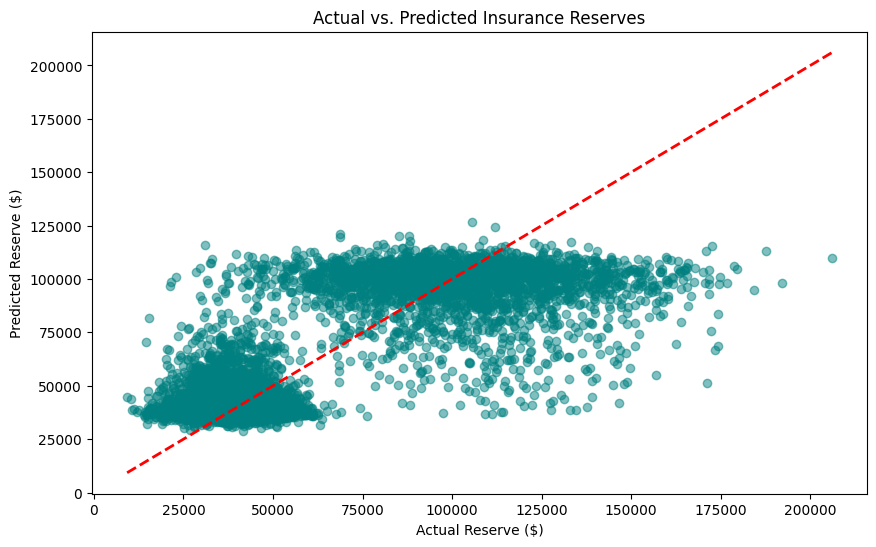

In [6]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Preparing X (Features) and y (Target)
X = df_final.drop(columns=['Claim_ID', 'Incurred_Reserve'])
y = df_final['Incurred_Reserve']

# Split into Training (80%) and Testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and Training the XGBoost Regressor
# We use 'absolute_error' because insurance reserves care about being 
# off by a specific dollar amount.
print("Training the Claims Prediction Model...")
model_xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    n_jobs=-1,
    early_stopping_rounds=50,
    eval_metric="mae"
)

model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Evaluating the Model
predictions = model_xgb.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"\nModel Training Complete!")
print(f"Mean Absolute Error: ${mae:,.2f}")
print(f"R-squared Score: {r2:.4f}")

# Visualizing the Results: Predicted vs. Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Reserve ($)')
plt.ylabel('Predicted Reserve ($)')
plt.title('Actual vs. Predicted Insurance Reserves')
plt.show()

In [7]:
def real_world_test(description):
    # 1. Vectorize
    vec = model.encode([description])
    # 2. Predict
    val = model_xgb.predict(vec)[0]
    
    print(f"Narrative: {description}")
    print(f"Predicted Reserve: ${val:,.2f}")
    print("-" * 40)

# Scenario A: Low Severity
real_world_test("Employee tripped over a computer cable and sustained a minor wrist sprain.")

# Scenario B: High Severity
real_world_test("Worker crushed by a falling shipping container, requiring immediate surgery for multiple fractures.")

# Scenario C: Catastrophic
real_world_test("Heavy machinery malfunction led to a traumatic leg amputation on the factory floor.")

Narrative: Employee tripped over a computer cable and sustained a minor wrist sprain.
Predicted Reserve: $37,918.39
----------------------------------------
Narrative: Worker crushed by a falling shipping container, requiring immediate surgery for multiple fractures.
Predicted Reserve: $37,645.27
----------------------------------------
Narrative: Heavy machinery malfunction led to a traumatic leg amputation on the factory floor.
Predicted Reserve: $74,046.09
----------------------------------------


Generating SHAP Summary Plot...


C:\Users\ABCD\AppData\Local\Temp\ipykernel_22936\1529000852.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test.iloc[:100], plot_type="bar")


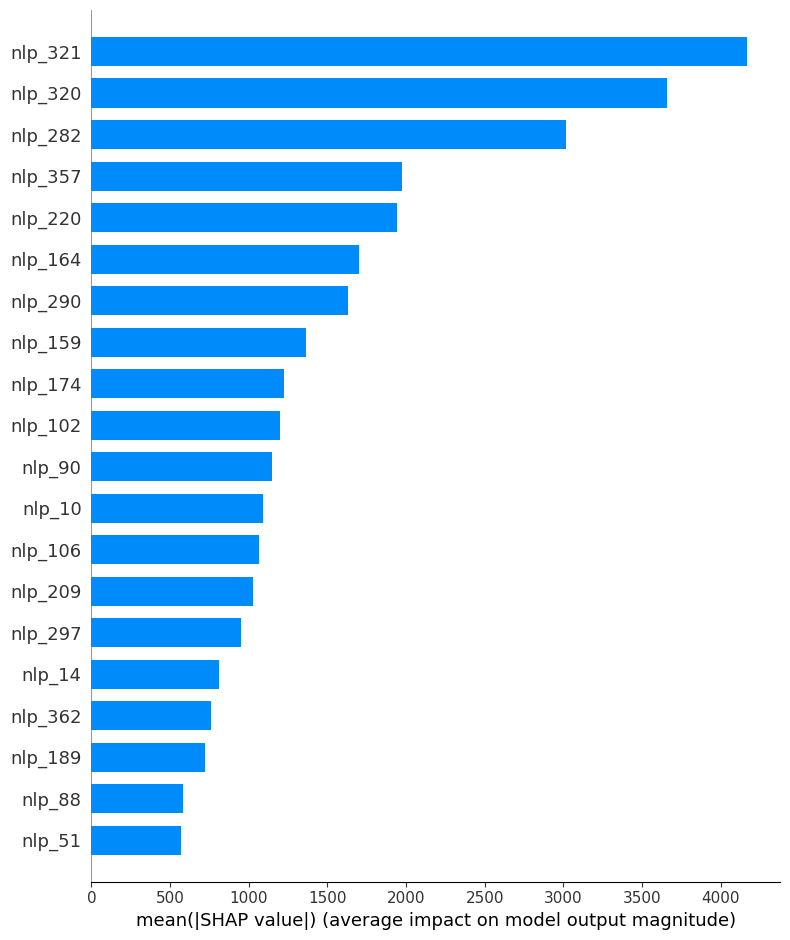


Individual Claim Breakdown:


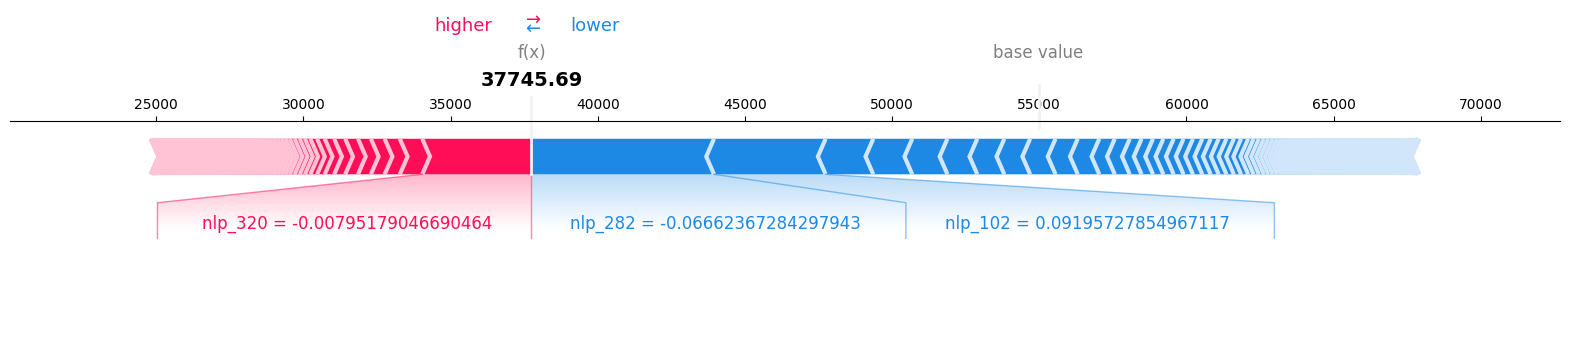

In [8]:
import shap

# Initialize the SHAP Explainer for XGBoost
explainer = shap.TreeExplainer(model_xgb)

# Calculate SHAP values for a subset of the test data
# We use 100 samples to keep the visualization clear and fast
shap_values = explainer.shap_values(X_test.iloc[:100])

# Summary Plot
# This tells us which of the 384 NLP features are the most powerful 
# "drivers" of the insurance reserve amount.
print("Generating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test.iloc[:100], plot_type="bar")

# The 'Force Plot' - Breaking down a SINGLE prediction
# This shows exactly how the model got from the 'Average' cost to its specific prediction.
print("\nIndividual Claim Breakdown:")
shap.initjs()
# Let's visualize the first prediction in the test set
shap.force_plot(
    explainer.expected_value, 
    shap_values[0, :], 
    X_test.iloc[0, :],
    matplotlib=True
)

In [10]:
import joblib
import json

# Save the underlying Booster (more reliable for XGBoost)
# This avoids the '_estimator_type' error
model_xgb.get_booster().save_model("claims_model.json")

# Save the SHAP Explainer
joblib.dump(explainer, "shap_explainer.pkl")

# Save a small reference set for SHAP
X_test.iloc[:100].to_pickle("shap_background.pkl")

# Save the column names
with open("column_names.json", "w") as f:
    json.dump(list(X.columns), f)

print("Model assets exported successfully without errors!")

Model assets exported successfully without errors!
